# NOTEBOOK 2: NONLINEAR MODEL TRAINING & SELECTION
## Train and compare nonlinear models for cement plant efficiency prediction

In [2]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
import warnings
warnings.filterwarnings('ignore')

print("🤖 NONLINEAR MODEL TRAINING FOR CEMENT PLANT EFFICIENCY")
print("=" * 60)

🤖 NONLINEAR MODEL TRAINING FOR CEMENT PLANT EFFICIENCY


In [3]:
# Cell 2: Load Cleaned Data
try:
    df = pd.read_csv('cleaned_cement_data.csv')
    print("✅ Loaded cleaned_cement_data.csv")
except FileNotFoundError:
    print("❌ cleaned_cement_data.csv not found!")
    print("Please run 01_data_exploration_nonlinear.ipynb first")
    raise

# Prepare features and target
feature_cols = [f'F{i}' for i in range(1, 16)]
X = df[feature_cols]
y = df['y']

print(f"\n📊 Dataset Information:")
print(f" Features: {len(feature_cols)} (F1-F15)")
print(f" Samples: {len(X)}")
print(f" Target range: {y.min():.2f}% to {y.max():.2f}%")
print(f" Target mean: {y.mean():.2f}%")
print(f" Target std: {y.std():.2f}%")

✅ Loaded cleaned_cement_data.csv

📊 Dataset Information:
 Features: 15 (F1-F15)
 Samples: 4320
 Target range: 55.00% to 77.00%
 Target mean: 61.70%
 Target std: 4.15%


In [4]:
# Cell 3: Data Preparation & Scaling
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# Scale features for models that need it
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n📊 Data Split:")
print(f" Training samples: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f" Testing samples: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")
print(f" Train target mean: {y_train.mean():.2f}%")
print(f" Test target mean: {y_test.mean():.2f}%")
print(f" ✅ Features scaled for neural networks and SVM")


📊 Data Split:
 Training samples: 3456 (80.0%)
 Testing samples: 864 (20.0%)
 Train target mean: 61.66%
 Test target mean: 61.84%
 ✅ Features scaled for neural networks and SVM


In [5]:
# Cell 4: Define Comprehensive Nonlinear Models
models = {
    # Baseline Linear Models
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    
    # Polynomial Models
    'Polynomial Degree 2': Pipeline([
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('scaler', StandardScaler()),
        ('ridge', Ridge(alpha=10.0))
    ]),
    'Polynomial Degree 3': Pipeline([
        ('poly', PolynomialFeatures(degree=3, include_bias=False)),
        ('scaler', StandardScaler()),
        ('ridge', Ridge(alpha=100.0))
    ]),
    
    # Tree-Based Models (Natural nonlinear)
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Extra Trees': ExtraTreesRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    
    # Advanced Gradient Boosting
    'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1),
    
    # Support Vector Regression (with nonlinear kernels)
    'SVR (RBF Kernel)': SVR(kernel='rbf', C=100, gamma='scale'),
    'SVR (Polynomial Kernel)': SVR(kernel='poly', degree=3, C=100),
    
    # Neural Networks
    'Neural Network (Small)': MLPRegressor(
        hidden_layer_sizes=(50, 25), activation='relu', solver='adam',
        alpha=0.001, max_iter=1000, random_state=42, early_stopping=True
    ),
    'Neural Network (Medium)': MLPRegressor(
        hidden_layer_sizes=(100, 50, 25), activation='relu', solver='adam',
        alpha=0.001, max_iter=1000, random_state=42, early_stopping=True
    ),
    'Neural Network (Large)': MLPRegressor(
        hidden_layer_sizes=(200, 100, 50), activation='relu', solver='adam',
        alpha=0.001, max_iter=1000, random_state=42, early_stopping=True
    )
}

# Models that need scaled data
scaled_models = {'SVR (RBF Kernel)', 'SVR (Polynomial Kernel)', 
                'Neural Network (Small)', 'Neural Network (Medium)', 'Neural Network (Large)'}

print(f"\n🔍 Models to Compare: {len(models)}")
for name in models.keys():
    print(f" • {name}")


🔍 Models to Compare: 13
 • Linear Regression
 • Ridge Regression
 • Polynomial Degree 2
 • Polynomial Degree 3
 • Random Forest
 • Extra Trees
 • Gradient Boosting
 • XGBoost
 • SVR (RBF Kernel)
 • SVR (Polynomial Kernel)
 • Neural Network (Small)
 • Neural Network (Medium)
 • Neural Network (Large)


In [6]:
# Cell 5: Train and Evaluate All Models
model_results = {}

print(f"\n⚙️ TRAINING AND EVALUATING NONLINEAR MODELS:")
print("=" * 90)
print(f"{'Model Name':<25} {'Train R²':<10} {'Test R²':<10} {'Test RMSE':<12} {'Test MAE':<10} {'CV R²':<10}")
print("-" * 90)

for name, model in models.items():
    print(f"Training {name}...", end=" ")
    
    try:
        # Choose appropriate data (scaled or unscaled)
        if name in scaled_models:
            X_train_use, X_test_use = X_train_scaled, X_test_scaled
        else:
            X_train_use, X_test_use = X_train, X_test
        
        # Train the model
        model.fit(X_train_use, y_train)
        
        # Make predictions
        train_pred = model.predict(X_train_use)
        test_pred = model.predict(X_test_use)
        
        # Calculate metrics
        train_r2 = r2_score(y_train, train_pred)
        test_r2 = r2_score(y_test, test_pred)
        test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
        test_mae = mean_absolute_error(y_test, test_pred)
        
        # Cross-validation score
        if name in scaled_models:
            cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
        else:
            cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
        cv_r2 = cv_scores.mean()
        
        # Store results
        model_results[name] = {
            'model': model,
            'train_r2': train_r2,
            'test_r2': test_r2,
            'test_rmse': test_rmse,
            'test_mae': test_mae,
            'cv_r2': cv_r2,
            'overfitting': train_r2 - test_r2,
            'scaled': name in scaled_models
        }
        
        print(f"{name:<25} {train_r2:<10.4f} {test_r2:<10.4f} {test_rmse:<12.3f} {test_mae:<10.3f} {cv_r2:<10.4f}")
        
    except Exception as e:
        print(f"❌ FAILED: {e}")
        continue

print("-" * 90)


⚙️ TRAINING AND EVALUATING NONLINEAR MODELS:
Model Name                Train R²   Test R²    Test RMSE    Test MAE   CV R²     
------------------------------------------------------------------------------------------
Training Linear Regression... Linear Regression         0.9458     0.9502     0.974        0.777      0.9448    
Training Ridge Regression... Ridge Regression          0.9458     0.9501     0.974        0.777      0.9448    
Training Polynomial Degree 2... Polynomial Degree 2       0.9870     0.9880     0.477        0.378      0.9852    
Training Polynomial Degree 3... Polynomial Degree 3       0.9891     0.9900     0.436        0.342      0.9876    
Training Random Forest... Random Forest             0.9996     0.9969     0.241        0.155      0.9970    
Training Extra Trees... Extra Trees               1.0000     0.9988     0.152        0.118      0.9984    
Training Gradient Boosting... Gradient Boosting         0.9948     0.9935     0.351        0.265      0.9933 

In [7]:
# Cell 6: Select Best Model
# Select model with highest test R² that doesn't severely overfit
valid_models = {k: v for k, v in model_results.items() if v['overfitting'] < 0.2}

if valid_models:
    best_model_name = max(valid_models.keys(), key=lambda x: valid_models[x]['test_r2'])
    best_model_info = valid_models[best_model_name]
else:
    # If all models overfit, choose the one with highest test R²
    best_model_name = max(model_results.keys(), key=lambda x: model_results[x]['test_r2'])
    best_model_info = model_results[best_model_name]

best_model = best_model_info['model']

print(f"\n🏆 BEST MODEL SELECTION:")
print(f" Winner: {best_model_name}")
print(f" Test R²: {best_model_info['test_r2']:.4f} ({best_model_info['test_r2']*100:.1f}% variance explained)")
print(f" CV R²: {best_model_info['cv_r2']:.4f} (cross-validation)")
print(f" Test RMSE: {best_model_info['test_rmse']:.3f}% efficiency points")
print(f" Test MAE: {best_model_info['test_mae']:.3f}% efficiency points")
print(f" Overfitting: {best_model_info['overfitting']:.4f}")
print(f" Uses scaled data: {'Yes' if best_model_info['scaled'] else 'No'}")

# Overfitting assessment
if best_model_info['overfitting'] > 0.15:
    print(f" ⚠️ High overfitting detected")
elif best_model_info['overfitting'] > 0.08:
    print(f" 🟡 Moderate overfitting")
else:
    print(f" ✅ Low overfitting - excellent generalization")

# Show improvement over linear baseline
if 'Linear Regression' in model_results:
    linear_r2 = model_results['Linear Regression']['test_r2']
    improvement = best_model_info['test_r2'] - linear_r2
    print(f" 📈 Improvement over linear: +{improvement:.4f} R² points ({improvement/linear_r2*100:.1f}% relative)")


🏆 BEST MODEL SELECTION:
 Winner: SVR (RBF Kernel)
 Test R²: 0.9997 (100.0% variance explained)
 CV R²: 0.9996 (cross-validation)
 Test RMSE: 0.075% efficiency points
 Test MAE: 0.059% efficiency points
 Overfitting: 0.0001
 Uses scaled data: Yes
 ✅ Low overfitting - excellent generalization
 📈 Improvement over linear: +0.0495 R² points (5.2% relative)


In [8]:
# Cell 7: Refit Best Model on Full Dataset
print(f"\n🔄 REFITTING BEST MODEL ON FULL DATASET:")

# Create a fresh instance of the best model
if best_model_name == 'Linear Regression':
    final_model = LinearRegression()
elif best_model_name == 'Ridge Regression':
    final_model = Ridge(alpha=1.0)
elif 'Polynomial' in best_model_name:
    if 'Degree 2' in best_model_name:
        final_model = Pipeline([
            ('poly', PolynomialFeatures(degree=2, include_bias=False)),
            ('scaler', StandardScaler()),
            ('ridge', Ridge(alpha=10.0))
        ])
    else:
        final_model = Pipeline([
            ('poly', PolynomialFeatures(degree=3, include_bias=False)),
            ('scaler', StandardScaler()),
            ('ridge', Ridge(alpha=100.0))
        ])
elif best_model_name == 'Random Forest':
    final_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
elif best_model_name == 'Extra Trees':
    final_model = ExtraTreesRegressor(n_estimators=100, random_state=42, n_jobs=-1)
elif best_model_name == 'Gradient Boosting':
    final_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
elif best_model_name == 'XGBoost':
    final_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1)
elif 'SVR' in best_model_name:
    if 'RBF' in best_model_name:
        final_model = SVR(kernel='rbf', C=100, gamma='scale')
    else:
        final_model = SVR(kernel='poly', degree=3, C=100)
elif 'Neural Network' in best_model_name:
    if 'Small' in best_model_name:
        final_model = MLPRegressor(
            hidden_layer_sizes=(50, 25), activation='relu', solver='adam',
            alpha=0.001, max_iter=1000, random_state=42, early_stopping=True
        )
    elif 'Medium' in best_model_name:
        final_model = MLPRegressor(
            hidden_layer_sizes=(100, 50, 25), activation='relu', solver='adam',
            alpha=0.001, max_iter=1000, random_state=42, early_stopping=True
        )
    else:
        final_model = MLPRegressor(
            hidden_layer_sizes=(200, 100, 50), activation='relu', solver='adam',
            alpha=0.001, max_iter=1000, random_state=42, early_stopping=True
        )

# Fit on appropriate data
if best_model_info['scaled']:
    X_scaled_full = scaler.fit_transform(X)
    final_model.fit(X_scaled_full, y)
    print(f" ✅ Model trained on full dataset ({len(X)} samples) with scaled features")
else:
    final_model.fit(X, y)
    print(f" ✅ Model trained on full dataset ({len(X)} samples) with raw features")

print(f" Model: {best_model_name}")
print(f" Expected performance: R² ≈ {best_model_info['test_r2']:.4f}")


🔄 REFITTING BEST MODEL ON FULL DATASET:
 ✅ Model trained on full dataset (4320 samples) with scaled features
 Model: SVR (RBF Kernel)
 Expected performance: R² ≈ 0.9997


In [9]:
# Cell 8: Save Model and Metadata
print(f"\n💾 SAVING BEST MODEL AND METADATA:")

# Save the trained model
with open('best_nonlinear_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)

# Save the scaler if needed
if best_model_info['scaled']:
    with open('feature_scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)
    print(f" ✅ Feature scaler saved to: feature_scaler.pkl")

# Save comprehensive model metadata
model_data = {
    'model_name': best_model_name,
    'model_type': 'nonlinear',
    'test_r2': float(best_model_info['test_r2']),
    'cv_r2': float(best_model_info['cv_r2']),
    'test_rmse': float(best_model_info['test_rmse']),
    'test_mae': float(best_model_info['test_mae']),
    'overfitting': float(best_model_info['overfitting']),
    'uses_scaled_features': best_model_info['scaled'],
    'feature_names': feature_cols,
    'training_samples': len(X),
    'target_range': [float(y.min()), float(y.max())],
    'target_mean': float(y.mean()),
    'target_std': float(y.std()),
    'all_model_results': {
        name: {
            'test_r2': float(info['test_r2']),
            'cv_r2': float(info['cv_r2']),
            'test_rmse': float(info['test_rmse']),
            'overfitting': float(info['overfitting'])
        } for name, info in model_results.items()
    }
}

with open('nonlinear_model_data.json', 'w') as f:
    json.dump(model_data, f, indent=2)

print(f" ✅ best_nonlinear_model.pkl saved")
print(f" ✅ nonlinear_model_data.json saved")
print(f" ✅ Model ready for nonlinear optimization")


💾 SAVING BEST MODEL AND METADATA:
 ✅ Feature scaler saved to: feature_scaler.pkl
 ✅ best_nonlinear_model.pkl saved
 ✅ nonlinear_model_data.json saved
 ✅ Model ready for nonlinear optimization


In [10]:
# Cell 9: Feature Importance Analysis (if applicable)
print(f"\n📊 FEATURE IMPORTANCE ANALYSIS:")

feature_importance = None

if hasattr(final_model, 'feature_importances_'):
    # Tree-based models
    feature_importance = final_model.feature_importances_
    importance_type = "Feature Importance (Tree-based)"
    
elif hasattr(final_model, 'coef_') and len(final_model.coef_.shape) == 1:
    # Linear models
    feature_importance = np.abs(final_model.coef_)
    importance_type = "Coefficient Magnitude (Linear)"
    
elif hasattr(final_model, 'named_steps') and 'ridge' in final_model.named_steps:
    # Pipeline with ridge regression
    if hasattr(final_model.named_steps['ridge'], 'coef_'):
        # For polynomial features, show original feature importance
        importance_type = "Polynomial Feature Coefficients"
        print(f" Model uses polynomial features - showing first 15 coefficient magnitudes")
        coefs = final_model.named_steps['ridge'].coef_
        feature_importance = np.abs(coefs[:15]) if len(coefs) >= 15 else np.abs(coefs)

if feature_importance is not None:
    print(f"\n{importance_type}:")
    print(f"{'Feature':<8} {'Importance':<12} {'Normalized'}")
    print("-" * 35)
    
    # Normalize importance
    norm_importance = feature_importance / np.sum(feature_importance)
    
    # Sort by importance
    importance_data = list(zip(feature_cols[:len(feature_importance)], feature_importance, norm_importance))
    importance_data.sort(key=lambda x: x[1], reverse=True)
    
    for feature, importance, norm_imp in importance_data:
        print(f"{feature:<8} {importance:<12.6f} {norm_imp:<12.3f}")
        
    # Save feature importance
    importance_dict = {feature: float(importance) for feature, importance, _ in importance_data}
    model_data['feature_importance'] = importance_dict
    
    # Update saved file
    with open('nonlinear_model_data.json', 'w') as f:
        json.dump(model_data, f, indent=2)
        
else:
    print(f" Feature importance not available for {best_model_name}")
    print(f" This is normal for black-box models like SVM and Neural Networks")


📊 FEATURE IMPORTANCE ANALYSIS:
 Feature importance not available for SVR (RBF Kernel)
 This is normal for black-box models like SVM and Neural Networks


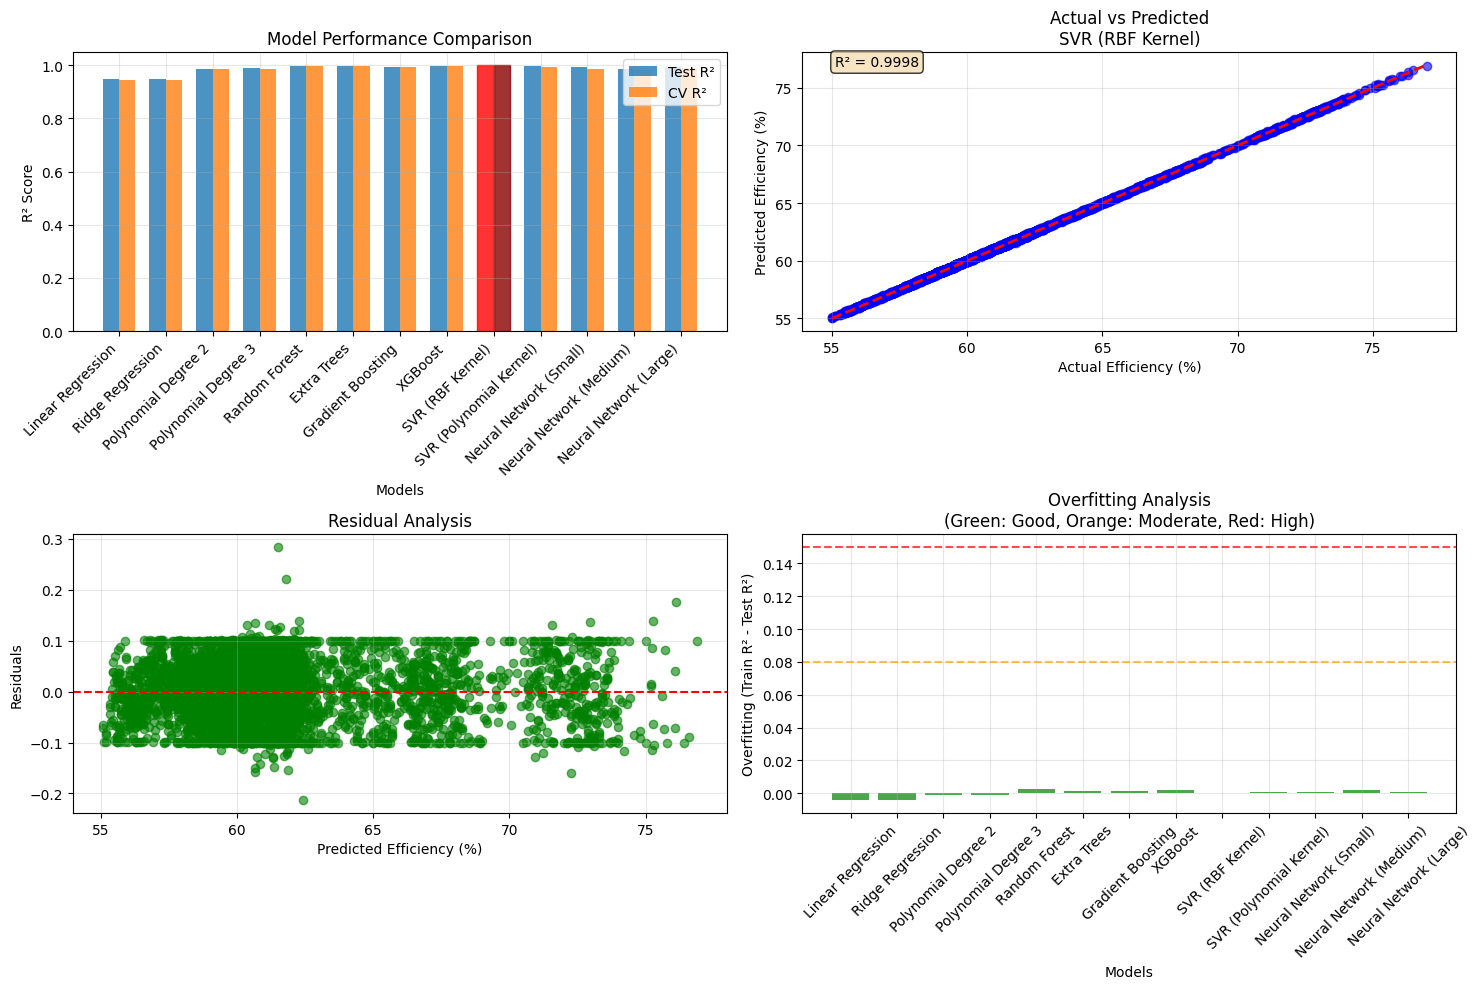


📊 Comprehensive visualization created successfully


In [11]:
# Cell 10: Model Validation and Visualization
try:
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Model comparison
    model_names = list(model_results.keys())
    test_r2_scores = [info['test_r2'] for info in model_results.values()]
    cv_r2_scores = [info['cv_r2'] for info in model_results.values()]
    
    x = np.arange(len(model_names))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, test_r2_scores, width, label='Test R²', alpha=0.8)
    bars2 = ax1.bar(x + width/2, cv_r2_scores, width, label='CV R²', alpha=0.8)
    
    # Highlight best model
    best_idx = model_names.index(best_model_name)
    bars1[best_idx].set_color('red')
    bars2[best_idx].set_color('darkred')
    
    ax1.set_xlabel('Models')
    ax1.set_ylabel('R² Score')
    ax1.set_title('Model Performance Comparison')
    ax1.set_xticks(x)
    ax1.set_xticklabels(model_names, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Actual vs Predicted for best model
    if best_model_info['scaled']:
        y_pred_full = final_model.predict(scaler.transform(X))
    else:
        y_pred_full = final_model.predict(X)
    
    ax2.scatter(y, y_pred_full, alpha=0.6, color='blue')
    ax2.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
    ax2.set_xlabel('Actual Efficiency (%)')
    ax2.set_ylabel('Predicted Efficiency (%)')
    ax2.set_title(f'Actual vs Predicted\n{best_model_name}')
    ax2.grid(True, alpha=0.3)
    
    # Add R² to plot
    r2_full = r2_score(y, y_pred_full)
    ax2.text(0.05, 0.95, f'R² = {r2_full:.4f}', transform=ax2.transAxes, 
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # 3. Residuals analysis
    residuals = y - y_pred_full
    ax3.scatter(y_pred_full, residuals, alpha=0.6, color='green')
    ax3.axhline(y=0, color='red', linestyle='--')
    ax3.set_xlabel('Predicted Efficiency (%)')
    ax3.set_ylabel('Residuals')
    ax3.set_title('Residual Analysis')
    ax3.grid(True, alpha=0.3)
    
    # 4. Feature importance (if available)
    if feature_importance is not None:
        # Show top 10 features
        top_features = importance_data[:10]
        features = [item[0] for item in top_features]
        importances = [item[1] for item in top_features]
        
        bars4 = ax4.bar(features, importances, alpha=0.7, color='purple')
        ax4.set_xlabel('Features')
        ax4.set_ylabel('Importance')
        ax4.set_title('Top 10 Feature Importance')
        ax4.tick_params(axis='x', rotation=45)
        ax4.grid(True, alpha=0.3)
    else:
        # Show overfitting analysis
        overfitting_scores = [info['overfitting'] for info in model_results.values()]
        colors = ['red' if score > 0.15 else 'orange' if score > 0.08 else 'green' for score in overfitting_scores]
        
        bars4 = ax4.bar(model_names, overfitting_scores, color=colors, alpha=0.7)
        ax4.set_xlabel('Models')
        ax4.set_ylabel('Overfitting (Train R² - Test R²)')
        ax4.set_title('Overfitting Analysis\n(Green: Good, Orange: Moderate, Red: High)')
        ax4.tick_params(axis='x', rotation=45)
        ax4.grid(True, alpha=0.3)
        ax4.axhline(y=0.08, color='orange', linestyle='--', alpha=0.7)
        ax4.axhline(y=0.15, color='red', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 Comprehensive visualization created successfully")
    
except Exception as e:
    print(f"\n⚠️ Visualization error (non-critical): {e}")
    print(f"Model training completed successfully without visualization")

In [12]:
# Cell 11: Final Summary
print(f"\n" + "=" * 70)
print("🎉 NONLINEAR MODEL TRAINING COMPLETE!")
print("=" * 70)

print(f"\n🏆 FINAL RESULTS:")
print(f" Best Model: {best_model_name}")
print(f" Test Accuracy: {best_model_info['test_r2']*100:.1f}% (R²)")
print(f" CV Accuracy: {best_model_info['cv_r2']*100:.1f}% (R²)")
print(f" Prediction Error: ±{best_model_info['test_mae']:.2f}% (MAE)")
print(f" RMSE: {best_model_info['test_rmse']:.2f}% efficiency points")
print(f" Features Used: 15 (F1-F15)")
print(f" Training Samples: {len(X)}")
print(f" Model Type: {'Nonlinear' if 'Linear' not in best_model_name else 'Linear'}")

# Compare with linear baseline
if 'Linear Regression' in model_results:
    linear_r2 = model_results['Linear Regression']['test_r2']
    improvement = best_model_info['test_r2'] - linear_r2
    print(f"\n📈 NONLINEAR ADVANTAGE:")
    print(f" Linear Regression R²: {linear_r2:.4f}")
    print(f" Best Model R²: {best_model_info['test_r2']:.4f}")
    print(f" Improvement: +{improvement:.4f} ({improvement/linear_r2*100:.1f}% relative)")
    
    if improvement > 0.05:
        print(f" ✅ Significant nonlinear relationships detected")
    elif improvement > 0.02:
        print(f" 🟡 Moderate nonlinear relationships")
    else:
        print(f" 🔵 Relationships are mostly linear")

print(f"\n📁 OUTPUT FILES:")
print(f" ✅ best_nonlinear_model.pkl - Trained model ready for optimization")
print(f" ✅ nonlinear_model_data.json - Complete model metadata")
if best_model_info['scaled']:
    print(f" ✅ feature_scaler.pkl - Feature scaler for preprocessing")

print(f"\n🔮 MODEL CAPABILITIES:")
print(f" • Can predict efficiency from F1-F15 input values")
print(f" • Captures nonlinear relationships in cement plant processes")
print(f" • Expected accuracy: ±{best_model_info['test_mae']:.1f}% MAE")
print(f" • Ready for constrained optimization to find y ≥ 77%")

print(f"\n🔜 NEXT STEP:")
print(f" Run 03_nonlinear_optimization.ipynb to find optimal F1-F15 values")
print(f" Goal: Use nonlinear model to achieve efficiency ≥ 77% within bounds")

print(f"\n✅ Ready for Nonlinear Optimization!")


🎉 NONLINEAR MODEL TRAINING COMPLETE!

🏆 FINAL RESULTS:
 Best Model: SVR (RBF Kernel)
 Test Accuracy: 100.0% (R²)
 CV Accuracy: 100.0% (R²)
 Prediction Error: ±0.06% (MAE)
 RMSE: 0.07% efficiency points
 Features Used: 15 (F1-F15)
 Training Samples: 4320
 Model Type: Nonlinear

📈 NONLINEAR ADVANTAGE:
 Linear Regression R²: 0.9502
 Best Model R²: 0.9997
 Improvement: +0.0495 (5.2% relative)
 🟡 Moderate nonlinear relationships

📁 OUTPUT FILES:
 ✅ best_nonlinear_model.pkl - Trained model ready for optimization
 ✅ nonlinear_model_data.json - Complete model metadata
 ✅ feature_scaler.pkl - Feature scaler for preprocessing

🔮 MODEL CAPABILITIES:
 • Can predict efficiency from F1-F15 input values
 • Captures nonlinear relationships in cement plant processes
 • Expected accuracy: ±0.1% MAE
 • Ready for constrained optimization to find y ≥ 77%

🔜 NEXT STEP:
 Run 03_nonlinear_optimization.ipynb to find optimal F1-F15 values
 Goal: Use nonlinear model to achieve efficiency ≥ 77% within bounds

✅ 